# Fisher Discriminant Analysis

First off we import necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from numpy.linalg import inv, eig

We define the number of points in each class, covariance matrix and mean of every class in accordance with the requirements of the exercise.

In [2]:
n = 30
cov = np.array([[1, 0], [0, 1]])
means = {'A': np.array([-1, 1]), 'B': np.array([2, 4]), 'C': np.array([-2, 2])}

We generate the data from multivariate normal distribution and insert it into the dataframe

In [3]:
data = pd.DataFrame(index=range(n * len(means)), columns=['x', 'y', 'label'])
for i, (label, mean) in enumerate(means.items()):
    data.loc[i*n:((i+1)*n)-1, ['x', 'y']] = np.random.multivariate_normal(mean, cov, n)
    data.loc[i*n:((i+1)*n)-1, ['label']] = label

Next we define a function that plots the points from the dataframe.

In [4]:
def plot_points(data):
    fig = plt.figure(figsize=(8, 6))
    sns.set_style('white')
    sns.set_palette('muted')
    sns.scatterplot(data=data, x='x', y='y', hue='label', legend=False, edgecolor='black').set(xlim=(-5, 5), ylim=(-2, 6))

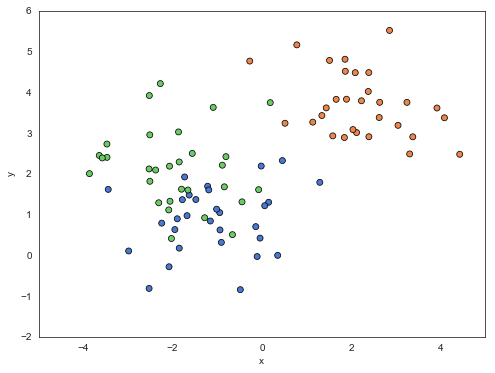

In [5]:
plot_points(data)

## Determination of optimal direction

Before we move on to computing of optimal direction, we should update means of the classes and covariance matrix corresponding to the generated points.

In [6]:
means = {label: np.array(np.mean(data.loc[data['label'] == label])) for label in means.keys()}
cov = {label: np.cov(data.loc[data['label'] == label][['x', 'y']].values.T.astype(float)) for label in means.keys()}

We compute a mean of all the points without distinguishing classes. Next we compute between class covariance matrix based on the equation:

\begin{equation}
\boldsymbol{B} = \frac{1}{g - 1}\sum_{k=1}^{g}n_{k}(\boldsymbol{m_{k}} - \boldsymbol{m})(\boldsymbol{m_{k}} - \boldsymbol{m})^{T}
\end{equation}

and within class covariance matrix based on the equation:

\begin{equation}
\boldsymbol{W} = \frac{1}{n - g}\sum_{k=1}^{g}(n_{k} - 1)\boldsymbol{S_{k}}.
\end{equation}

However we can simplify the above expression into the form:

\begin{equation}
\boldsymbol{W} = \frac{1}{g}\sum_{k=1}^{g}\boldsymbol{S_{k}}
\end{equation}

because number of points is identical for every class.

In [7]:
mean = np.mean(np.array([means[i] for i in means]), axis=0)
outer_products = [np.outer(value - mean, value - mean) for value in means.values()]
bc_cov = sum(n * outer_products) / (len(means) - 1)
wc_cov = np.mean(np.array([cov[i] for i in cov]), axis=0)

We define the matrix $\boldsymbol{U}$:

\begin{equation}
\boldsymbol{U} = \boldsymbol{W^{-1}}\boldsymbol{B},
\end{equation}

determine eigenvalues and eigenvectors of that matrix and choose the eigenvector corresponding to the maximum eigenvalue.

In [8]:
U = np.dot(inv(wc_cov), bc_cov)
eig_values, eig_vectors = eig(U)
a = eig_vectors[:, np.argmax(eig_values)]

## Projection of points on the line and decision boundary

Having vector $\boldsymbol{a}$ that maximizes the expression:

\begin{equation}
\boldsymbol{J} = \frac{\boldsymbol{a^{T}Ba}}{\boldsymbol{a^{T}Wa}}
\end{equation}

it's possible to figure out the parameters of discriminant hyperplane.

In [9]:
slope = a[1] / a[0]
intercept = -0.5 * np.dot(a.T, np.sum(np.array([means[i] for i in means]), axis=0))

Now we can plot the line which the points will be projected on.

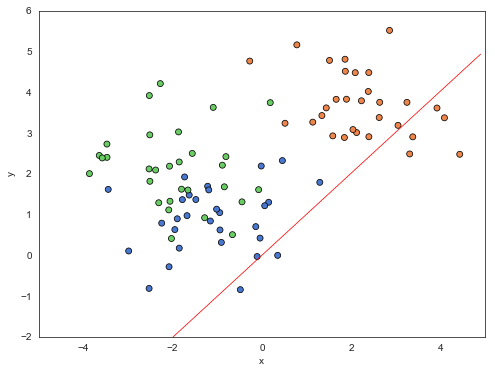

In [10]:
x = np.arange(-5, 5, 0.1)
y = slope * x

plot_points(data)
sns.lineplot(x, y, color='red', linewidth=0.75);

After that we define a function that projects the points on the line.

In [11]:
def projection(data, slope):
    data_cp = data.copy()
    data_cp['x'] = (data['x'] + slope * data['y']) / (slope**2 + 1)
    data_cp['y'] = slope * data_cp['x']
    return data_cp

In [12]:
proj_data = projection(data, slope)

Finally we can plot the projected points and the decision boundary that satisfies the equation:

\begin{equation}
a_{0}x + a_{1}y + b = 0,
\end{equation}

where $a_{0}$ and $a_{1}$ are the elements of vector $\boldsymbol{a}$ and $b$ is the intercept.

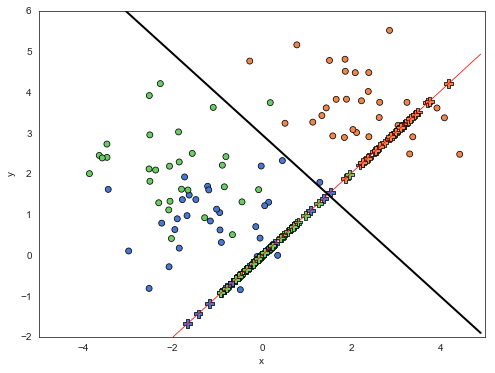

In [13]:
plot_points(data)
sns.lineplot(x, y, color='red', linewidth=0.75)
sns.scatterplot(data=proj_data, x='x', y='y', hue='label', legend=False, marker='P', s=75, edgecolor='black')
sns.lineplot(x, -1 / slope * x - intercept / a[1], color='black', linewidth=2);

As we can see it's impossible to separate all three classes satisfying the requirements of the exercise with Fisher Discriminant Analysis method.